In [94]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [95]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek
import numpy as np

In [98]:
#red
red_wine_path = winequality-red.csv
red_wine_df = pd.read_csv(red_wine_path)

#white
white_wine_path = 'winequality-white.csv
white_wine_df = pd.read_csv(white_wine_path)

print(red_wine_df.head())
print(white_wine_df.head())

  fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
0   7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5                                                                                                                     
1   7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5                                                                                                                     
2  7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...                                                                                                                     
3  11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...                                                                                                                     
4   7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5                                                                                                  

In [99]:
red_wine_df = pd.read_csv(red_wine_path, delimiter=';')
white_wine_df = pd.read_csv(white_wine_path, delimiter=';')

In [100]:
#combining the dataset, adding 'red=1/white=0'column
red_wine_df['wine_type'] = '1'
white_wine_df['wine_type'] = '0'
#renaming column from 'wine_type' to 'red'
red_wine_df = red_wine_df.rename(columns={'wine_type': 'red'})
white_wine_df = white_wine_df.rename(columns={'wine_type': 'red'})

In [101]:
merged_wine_df = pd.concat([red_wine_df, white_wine_df], axis=0)
merged_wine_df.reset_index(drop=True, inplace=True)

In [102]:
print("Merged Wine Dataset:")
print(merged_wine_df.head())

Merged Wine Dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality red  
0      9.4        5   1  
1      9.8   

In [103]:
print("\nDistribution of Quality Values:")
print(merged_wine_df['quality'].value_counts())


Distribution of Quality Values:
quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64


In [104]:
merged_wine_df['quality'].unique()

array([5, 6, 7, 4, 8, 3, 9])

In [105]:
#creating two scenarios

# First scenario: 3,4,5 as bad (0) and 7,8,9 as good (1)
merged_wine_df["quality_binary_case1"] = merged_wine_df["quality"].apply(lambda x: 1 if x in [7, 8, 9] else (0 if x in [3, 4, 5] else None))

# Second scenario: 3,4 as bad (0) and 8,9 as good (1)
merged_wine_df["quality_binary_case2"] = merged_wine_df["quality"].apply(lambda x: 1 if x in [8, 9] else (0 if x in [3, 4] else None))

print(merged_wine_df[["quality", "quality_binary_case1", "quality_binary_case2"]])


      quality  quality_binary_case1  quality_binary_case2
0           5                   0.0                   NaN
1           5                   0.0                   NaN
2           5                   0.0                   NaN
3           6                   NaN                   NaN
4           5                   0.0                   NaN
...       ...                   ...                   ...
6492        6                   NaN                   NaN
6493        5                   0.0                   NaN
6494        6                   NaN                   NaN
6495        7                   1.0                   NaN
6496        6                   NaN                   NaN

[6497 rows x 3 columns]


In [106]:
# Function to downsample '1' class to reach ~10% minority proportion
def make_imbalanced(df, column, target_ratio=0.1):
    ones = df[df[column] == 1]
    zeros = df[df[column] == 0]
    
    # Calculate new minority size (target % of total dataset)
    new_minority_size = int(len(zeros) * target_ratio / (1 - target_ratio))
    
    # If calculated minority size is larger than available ones, keep all
    new_minority_size = min(new_minority_size, len(ones))
    
    ones_downsampled = ones.sample(n=new_minority_size, random_state=42)
    df_imbalanced = pd.concat([zeros, ones_downsampled])
    
    return df_imbalanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle


# Create imbalanced datasets
wine_imbalanced_1 = make_imbalanced(merged_wine_df, "quality_binary_case1", target_ratio=0.05)
wine_imbalanced_2 = make_imbalanced(merged_wine_df, "quality_binary_case2", target_ratio=0.08)

# Print counts and percentages
print("Imbalanced Case 1:\n")
print(wine_imbalanced_1["quality_binary_case1"].value_counts())
print()
print(wine_imbalanced_1["quality_binary_case1"].value_counts(normalize=True) * 100, "%\n")
print('---------------------------------------')
print("Imbalanced Case 2:\n")
print(wine_imbalanced_2["quality_binary_case2"].value_counts())
print()
print(wine_imbalanced_2["quality_binary_case2"].value_counts(normalize=True) * 100, "%")

Imbalanced Case 1:

quality_binary_case1
0.0    2384
1.0     125
Name: count, dtype: int64

quality_binary_case1
0.0    95.017935
1.0     4.982065
Name: proportion, dtype: float64 %

---------------------------------------
Imbalanced Case 2:

quality_binary_case2
0.0    246
1.0     21
Name: count, dtype: int64

quality_binary_case2
0.0    92.134831
1.0     7.865169
Name: proportion, dtype: float64 %


In [107]:
wine_imbalanced_1 = wine_imbalanced_1.drop(columns=['quality_binary_case2'])
wine_imbalanced_1

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,quality_binary_case1
0,7.6,0.36,0.49,11.3,0.046,87.0,221.0,0.99840,3.01,0.43,9.2,5,0,0.0
1,10.2,0.24,0.49,2.4,0.075,10.0,28.0,0.99780,3.14,0.61,10.4,5,1,0.0
2,6.2,0.27,0.47,1.2,0.146,28.0,105.0,0.99224,3.23,0.51,10.1,5,0,0.0
3,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,1,0.0
4,9.9,0.35,0.55,2.1,0.062,5.0,14.0,0.99710,3.26,0.79,10.6,5,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,9.2,0.16,0.49,2.0,0.044,18.0,107.0,0.99514,3.10,0.53,10.2,4,0,0.0
2505,6.0,0.20,0.71,1.6,0.150,10.0,54.0,0.99270,3.12,0.47,9.8,5,0,0.0
2506,6.7,0.26,0.26,4.0,0.079,35.5,216.0,0.99560,3.31,0.68,9.5,5,0,0.0
2507,7.3,0.30,0.74,13.5,0.039,46.0,165.0,0.99820,3.02,0.40,8.7,5,0,0.0


In [108]:
wine_imbalanced_2 = wine_imbalanced_2.drop(columns=['quality_binary_case1'])
wine_imbalanced_2

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,quality_binary_case2
0,7.2,0.400,0.62,10.8,0.041,70.0,189.0,0.99760,3.08,0.49,8.6,4,0,0.0
1,8.5,0.400,0.40,6.3,0.050,3.0,10.0,0.99566,3.28,0.56,12.0,4,1,0.0
2,7.6,0.310,0.23,12.7,0.054,20.0,139.0,0.99836,3.16,0.50,9.7,4,0,0.0
3,5.8,0.260,0.30,2.6,0.034,75.0,129.0,0.99020,3.20,0.38,11.5,4,0,0.0
4,7.1,0.210,0.28,2.7,0.034,23.0,111.0,0.99405,3.35,0.64,10.2,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,8.2,0.915,0.27,2.1,0.088,7.0,23.0,0.99620,3.26,0.47,10.0,4,1,0.0
263,7.2,0.615,0.10,1.4,0.068,25.0,154.0,0.99499,3.20,0.48,9.7,4,0,0.0
264,5.8,0.280,0.35,2.3,0.053,36.0,114.0,0.99240,3.28,0.50,10.2,4,0,0.0
265,8.0,0.550,0.17,8.2,0.040,13.0,60.0,0.99560,3.09,0.30,9.5,4,0,0.0


In [109]:
# Save imbalanced datasets to CSV files
#wine_imbalanced_1.to_csv("quality_binary_case1.csv", index=False)
#wine_imbalanced_2.to_csv("quality_binary_case2.csv", index=False)

In [110]:
# Summary statistics with 2 decimal places
print("Summary statistics for quality_binary_case1:\n", wine_imbalanced_1.describe().round(2), "\n")
print("----------------------------------------------------------------------")
print("Summary statistics for quality_binary_case2:\n", wine_imbalanced_2.describe().round(2), "\n")

Summary statistics for quality_binary_case1:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count        2509.00           2509.00      2509.00         2509.00   
mean            7.31              0.39         0.31            5.59   
std             1.27              0.19         0.16            4.87   
min             4.20              0.08         0.00            0.60   
25%             6.50              0.26         0.21            1.80   
50%             7.10              0.33         0.30            2.90   
75%             7.80              0.50         0.40            8.30   
max            15.90              1.58         1.00           23.50   

       chlorides  free sulfur dioxide  total sulfur dioxide  density       pH  \
count    2509.00              2509.00               2509.00  2509.00  2509.00   
mean        0.06                29.51                118.74     1.00     3.22   
std         0.04                19.63                 61.18     0.00   

In [111]:
# Check for duplicates
print("Duplicates in quality_binary_case1:", wine_imbalanced_1.duplicated().sum())
print("Duplicates in quality_binary_case2:", wine_imbalanced_2.duplicated().sum())

Duplicates in quality_binary_case1: 398
Duplicates in quality_binary_case2: 11


In [112]:
# Drop duplicates
wine_imbalanced_1 = wine_imbalanced_1.drop_duplicates()
wine_imbalanced_2 = wine_imbalanced_2.drop_duplicates()

In [113]:
wine_imbalanced_1.info()
print()
print("------------------------------------------------------")
print()
wine_imbalanced_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2111 entries, 0 to 2508
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2111 non-null   float64
 1   volatile acidity      2111 non-null   float64
 2   citric acid           2111 non-null   float64
 3   residual sugar        2111 non-null   float64
 4   chlorides             2111 non-null   float64
 5   free sulfur dioxide   2111 non-null   float64
 6   total sulfur dioxide  2111 non-null   float64
 7   density               2111 non-null   float64
 8   pH                    2111 non-null   float64
 9   sulphates             2111 non-null   float64
 10  alcohol               2111 non-null   float64
 11  quality               2111 non-null   int64  
 12  red                   2111 non-null   object 
 13  quality_binary_case1  2111 non-null   float64
dtypes: float64(12), int64(1), object(1)
memory usage: 247.4+ KB

----------------

In [114]:
wine_imbalanced_1["quality_binary_case1"] = wine_imbalanced_1["quality_binary_case1"].astype(int)
wine_imbalanced_2["quality_binary_case2"] = wine_imbalanced_2["quality_binary_case2"].astype(int)
wine_imbalanced_1["red"] = wine_imbalanced_1["red"].astype(int)
wine_imbalanced_2["red"] = wine_imbalanced_2["red"].astype(int)

/var/folders/hn/xpkpcn3926gcvpp04dl28xkc0000gn/T/ipykernel_19785/804117968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_imbalanced_1["quality_binary_case1"] = wine_imbalanced_1["quality_binary_case1"].astype(int)
/var/folders/hn/xpkpcn3926gcvpp04dl28xkc0000gn/T/ipykernel_19785/804117968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_imbalanced_2["quality_binary_case2"] = wine_imbalanced_2["quality_binary_case2"].astype(int)
/var/folders/hn/xpkpcn3926gcvpp04dl28xkc0000gn/T/ipykernel_197

In [115]:
 wine_imbalanced_1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,quality_binary_case1
0,7.6,0.36,0.49,11.3,0.046,87.0,221.0,0.99840,3.01,0.43,9.2,5,0,0
1,10.2,0.24,0.49,2.4,0.075,10.0,28.0,0.99780,3.14,0.61,10.4,5,1,0
2,6.2,0.27,0.47,1.2,0.146,28.0,105.0,0.99224,3.23,0.51,10.1,5,0,0
3,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5,1,0
4,9.9,0.35,0.55,2.1,0.062,5.0,14.0,0.99710,3.26,0.79,10.6,5,1,0


In [116]:
print("Imbalanced Case 1:\n")
print(wine_imbalanced_1["quality_binary_case1"].value_counts())
print()
print(wine_imbalanced_1["quality_binary_case1"].value_counts(normalize=True) * 100, "%\n")
print('---------------------------------------')
print("Imbalanced Case 2:\n")
print(wine_imbalanced_2["quality_binary_case2"].value_counts())
print()
print(wine_imbalanced_2["quality_binary_case2"].value_counts(normalize=True) * 100, "%")

Imbalanced Case 1:

quality_binary_case1
0    1988
1     123
Name: count, dtype: int64

quality_binary_case1
0    94.173378
1     5.826622
Name: proportion, dtype: float64 %

---------------------------------------
Imbalanced Case 2:

quality_binary_case2
0    236
1     20
Name: count, dtype: int64

quality_binary_case2
0    92.1875
1     7.8125
Name: proportion, dtype: float64 %


# VISUALIZATION

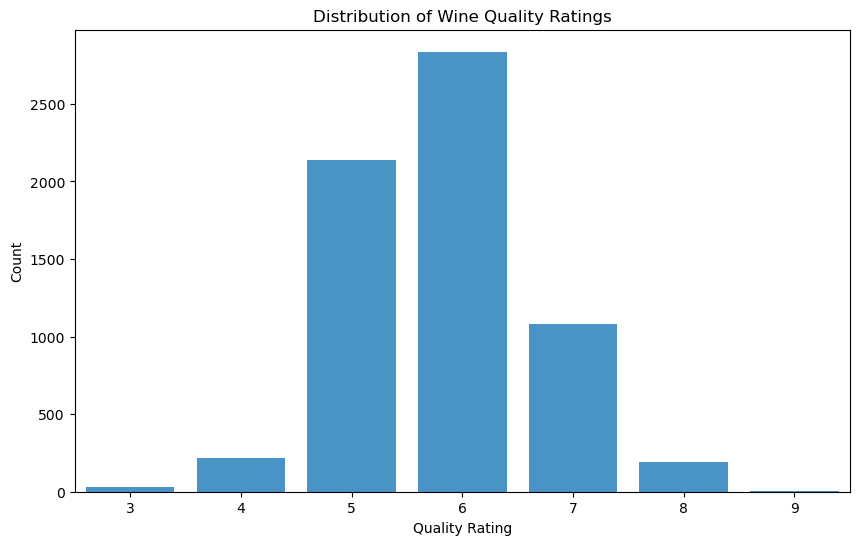

In [117]:
# 1. Distribution of initial wine quality
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_wine_df, x='quality', palette=['#3498db'])
plt.title('Distribution of Wine Quality Ratings')
plt.xlabel('Quality Rating')
plt.ylabel('Count')
plt.show()

# BINARY DATASET

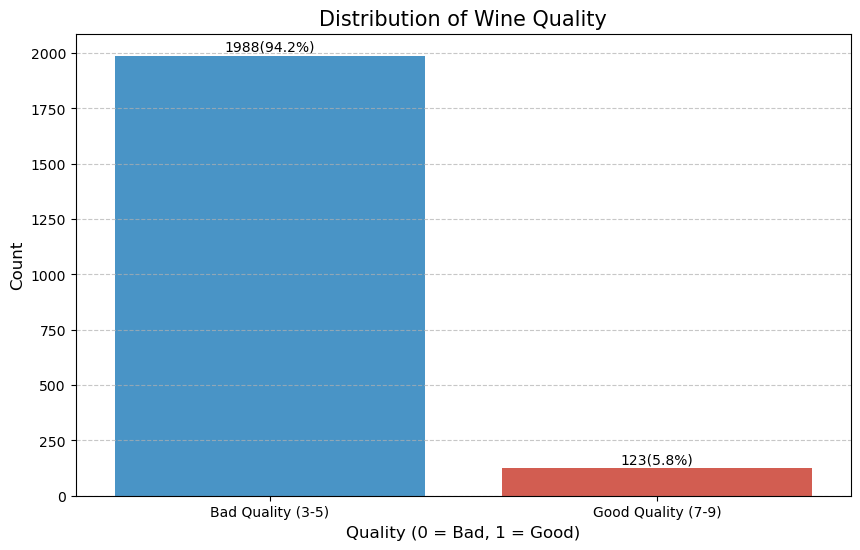

In [118]:
# 1. Distribution of wine quality (case 1)
plt.figure(figsize=(10, 6))
quality_counts = wine_imbalanced_1['quality_binary_case1'].value_counts()
sns.barplot(x=quality_counts.index, y=quality_counts.values, palette=['#3498db', '#e74c3c'])
plt.title('Distribution of Wine Quality', fontsize=15)
plt.xlabel('Quality (0 = Bad, 1 = Good)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Bad Quality (3-5)', 'Good Quality (7-9)'])
for i, count in enumerate(quality_counts.values):
    plt.text(i, count + 20, f"{count}({count/sum(quality_counts.values):.1%})", 
             ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [119]:
# 2. correlation heatmap

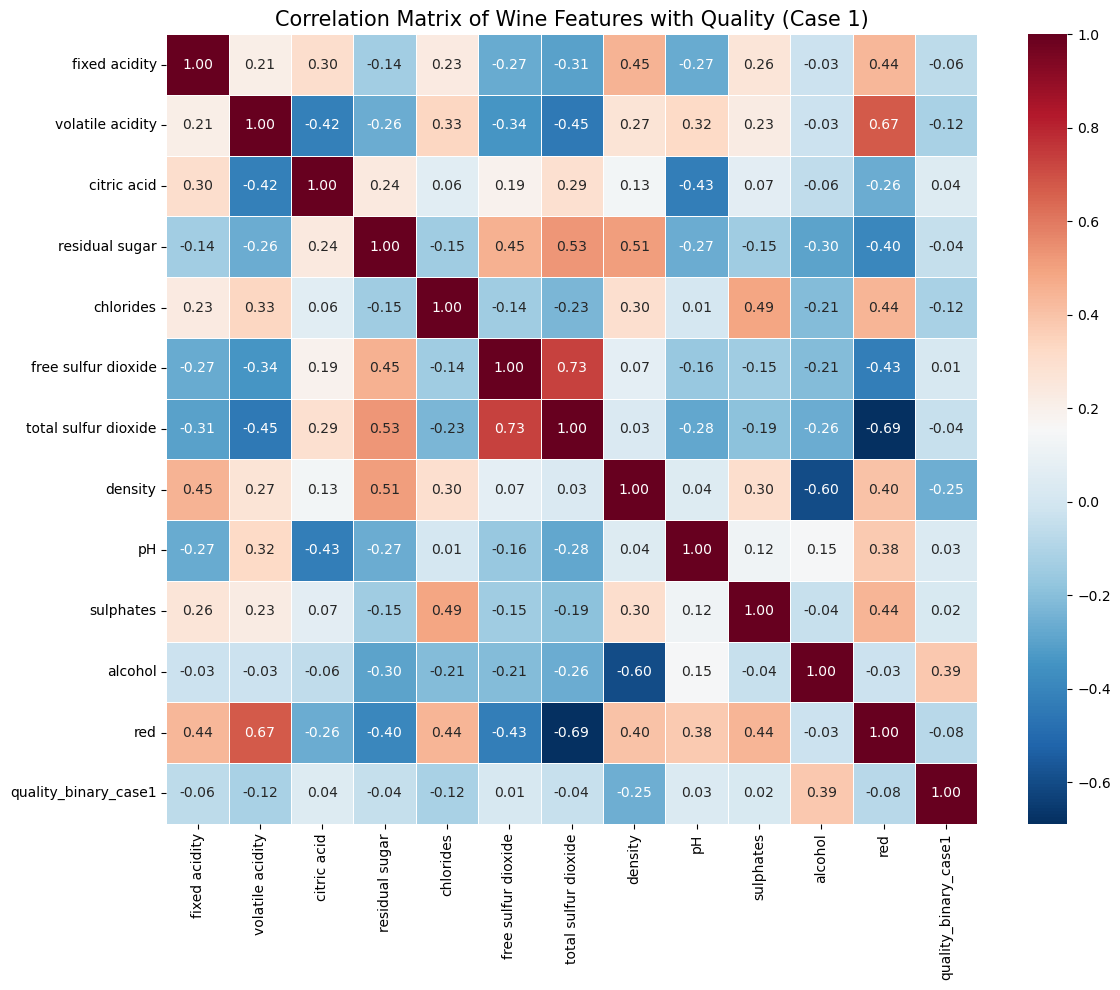

In [120]:
plt.figure(figsize=(12, 10))
# Include only numerical columns, quality_binary_case1, but exclude the original quality column
cols_to_use = [col for col in wine_imbalanced_1.select_dtypes(include=['float64', 'int64']).columns 
               if col != 'quality']
correlation = wine_imbalanced_1[cols_to_use].corr()
sns.heatmap(correlation, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Wine Features with Quality (Case 1)', fontsize=15)
plt.tight_layout()
plt.show()

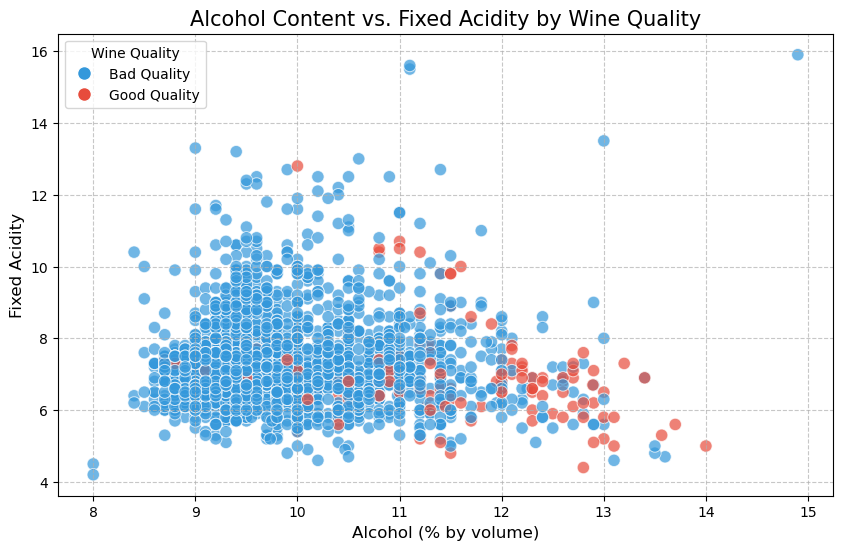

In [121]:
# 3. Alcohol, fixed acidity, Quality scatter plot
plt.figure(figsize=(10, 6))
# Creating a scatter plot with better colors
scatter = sns.scatterplot(x='alcohol', y='fixed acidity', 
                hue='quality_binary_case1', 
                data=wine_imbalanced_1, 
                palette=['#3498db', '#e74c3c'], 
                alpha=0.7, s=80)
plt.title('Alcohol Content vs. Fixed Acidity by Wine Quality', fontsize=15)
plt.xlabel('Alcohol (% by volume)', fontsize=12)
plt.ylabel('Fixed Acidity', fontsize=12)

# Manually create the legend to ensure correct colors
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
           markersize=10, label='Bad Quality'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
           markersize=10, label='Good Quality')
]
plt.legend(handles=legend_elements, title='Wine Quality')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [122]:
#Density plots of key chemical properties

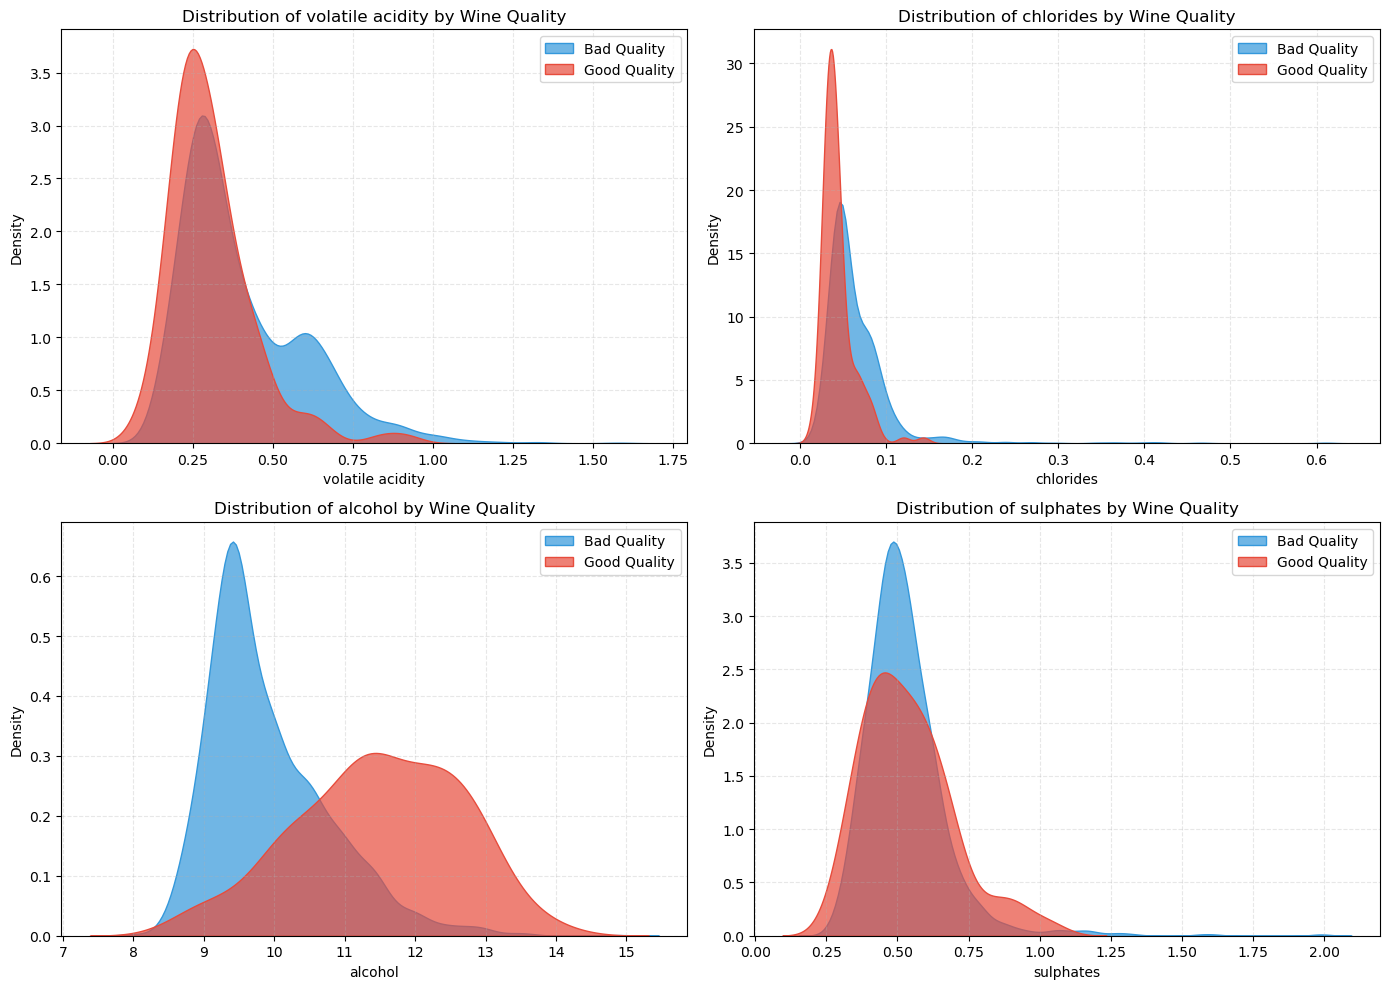

In [123]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

key_features = ['volatile acidity', 'chlorides', 'alcohol', 'sulphates']

for i, feature in enumerate(key_features):
    for quality in [0, 1]:
        subset = wine_imbalanced_1[wine_imbalanced_1['quality_binary_case1'] == quality]
        sns.kdeplot(subset[feature], fill=True, 
                   color='#3498db' if quality == 0 else '#e74c3c',
                   label='Bad Quality' if quality == 0 else 'Good Quality',
                   ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distribution of {feature} by Wine Quality', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

This visualization shows how four key chemical properties differ between good and bad quality wines

Volatile Acidity: Good wines (red) - lower volatile acidity than bad wines (blue), clustering around 0.25, while bad wines show a wider distribution.
Chlorides: Good wines have consistently lower chloride levels, peaking sharply around 0.05, whereas bad wines show more variability and higher concentrations.
Alcohol: Clear separation between classes - good wines have significantly higher alcohol content (11-13%), while bad wines cluster around 9-10%.
Sulphates: Good wines show a wider distribution of sulphate levels than bad wines.

/Users/dobrosiasupernak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1000 with 0 Axes>

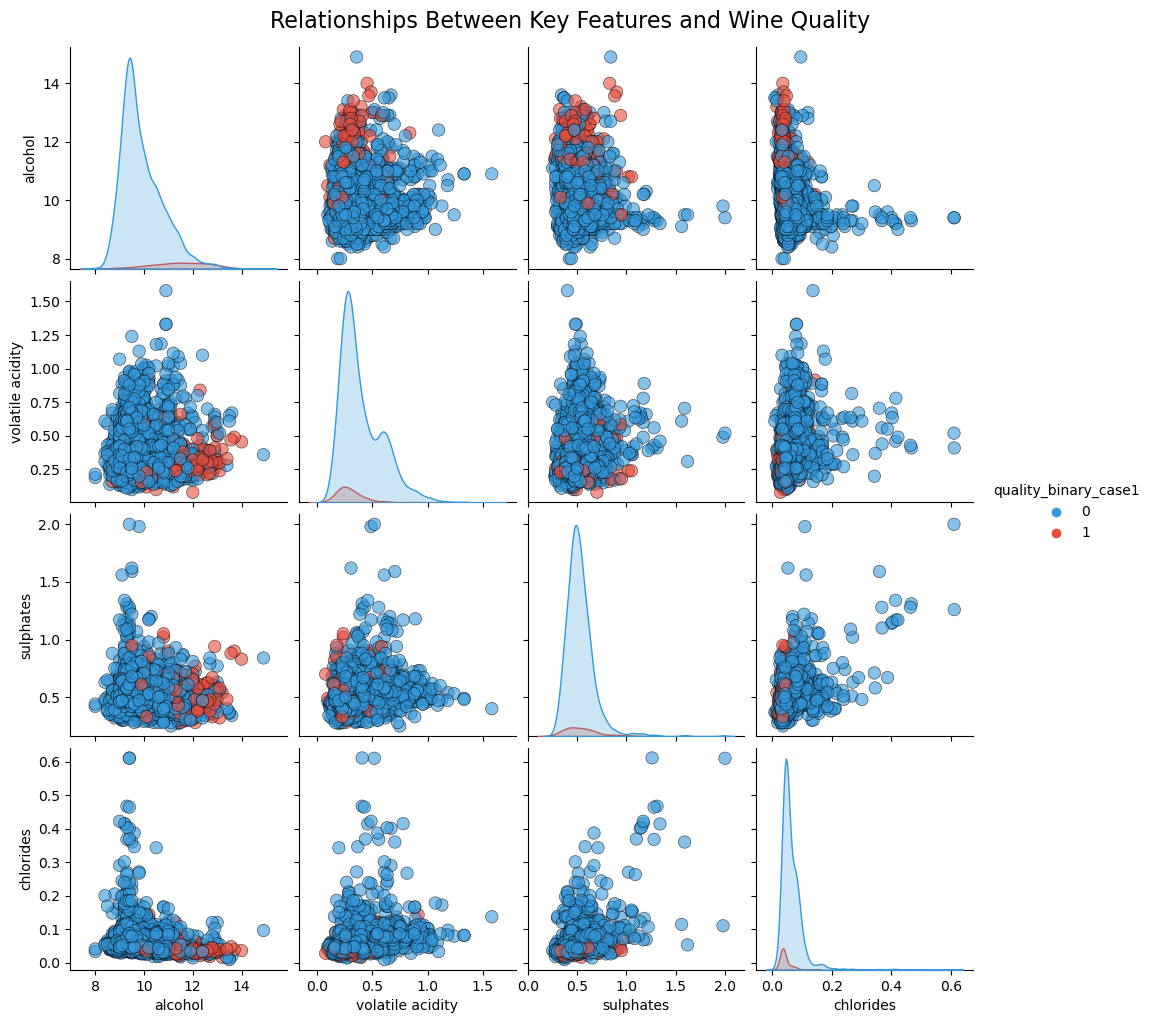

In [124]:
important_features = ['alcohol', 'volatile acidity', 'sulphates', 'chlorides', 'quality_binary_case1']
plt.figure(figsize=(12, 10))
sns.pairplot(wine_imbalanced_1[important_features], 
             hue='quality_binary_case1', 
             palette=['#3498db', '#e74c3c'],
             diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Relationships Between Key Features and Wine Quality', y=1.02, fontsize=16)
plt.show()

This pairplot shows relationships between key chemical properties

The diagonal shows density distributions for each property by quality.
The scatter plots show relationships between pairs of variables.

Key insights:

Alcohol vs. volatile acidity shows good wines clustering in the high-alcohol, low-acidity region
Alcohol vs. sulphates shows good wines tend toward higher values in both dimensions
Chlorides are consistently lower in good wines across all comparisons
The clearest separation between classes appears in the alcohol-related plots (again)

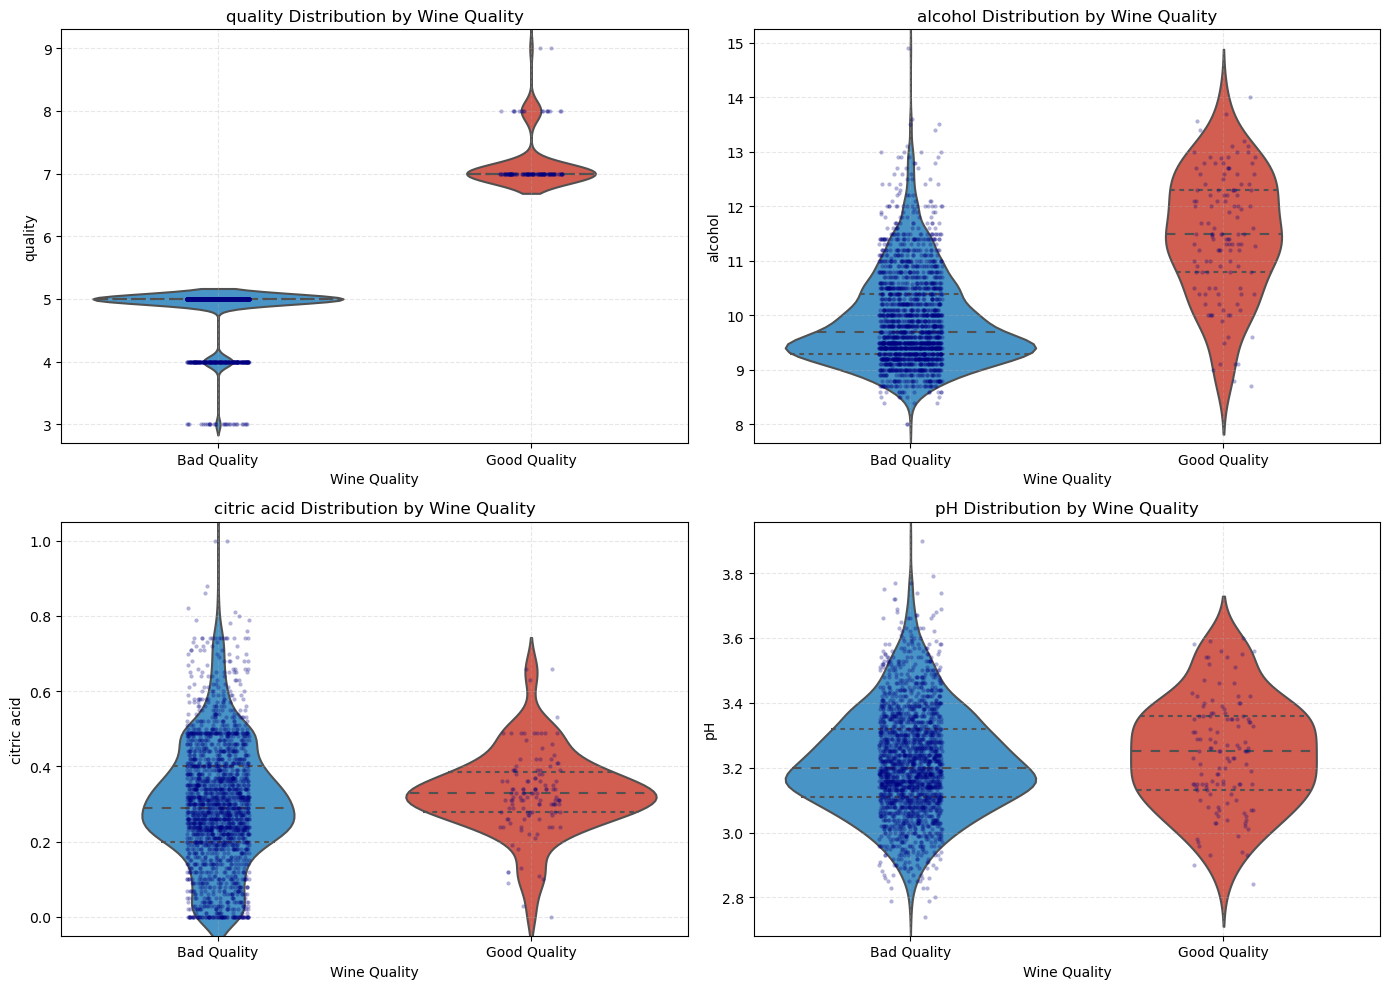

In [202]:
# Directly specify the top features
top_features = ['quality','alcohol', 'citric acid', 'pH']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.violinplot(x='quality_binary_case1', y=feature, data=wine_imbalanced_1, ax=axes[i], 
                  inner='quartile', palette=['#3498db', '#e74c3c'])
    # Add individual points for more detail
    sns.stripplot(x='quality_binary_case1', y=feature, data=wine_imbalanced_1, ax=axes[i],
                 size=3, color='navy', alpha=0.3, jitter=True)
    axes[i].set_title(f'{feature} Distribution by Wine Quality')
    axes[i].set_xlabel('Wine Quality')
    axes[i].set_xticklabels(['Bad Quality', 'Good Quality'])
    axes[i].grid(True, linestyle='--', alpha=0.3)
    
plt.tight_layout()
plt.show()

This set of violin plots shows the distribution of properties with data points

Quality: Shows the actual quality scores within each binary group (bad: 3-5, good: 7-9).
Alcohol: Clear separation between classes, with good wines having substantially higher alcohol content. The dashed lines indicate means/quartiles.
Citric Acid: Bad wines show more variability in citric acid content, while good wines have a narrower, more consistent distribution centered around 0.3.
pH: Slight difference between classes, with good wines showing a trend toward higher pH levels than bad wines.

# Problem Description
This project aims to predict wine quality based on chemical composition. Wine quality is traditionally assessed by human experts, which is subjective, time-consuming, and expensive. The challenge is to create an objective model that can accurately predict wine quality using measurable chemical properties, potentially automating part of the quality assessment process.

# Approach:

Explanatory data analysis:

Initial analysis of relationship between chemical properties and wine quality.
Identification of key features that most strongly correlate with quality ratings.

Model trainings (three different algorithms):
Logistic Regression,
Random Forest Classifier,
Gradient Boosting Classifier.

Modeling on balanced datasets - addressing data distribution issues (BorderlineSMOTE) to improve model performance

Comparison of models using accuracy, precision, recall, and F1-score.

Identification of the most reliable model for practical wine quality assessment.


# TRAINING

In [176]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
            'pH', 'sulphates', 'alcohol', 'red']

In [177]:
X = wine_imbalanced_1[features]
y_case1 = wine_imbalanced_1['quality_binary_case1']
y_case2 = wine_imbalanced_2['quality_binary_case2']

# quality_binary_case1

In [178]:
# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_case1, test_size=0.2, random_state=42)

Logistic Regression Performance:
Accuracy:  0.9409
Precision: 0.5000
Recall:    0.0800
F1 Score:  0.1379

Confusion Matrix:
True Negatives (TN): 396
False Positives (FP): 2
False Negatives (FN): 23
True Positives (TP): 2


/Users/dobrosiasupernak/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


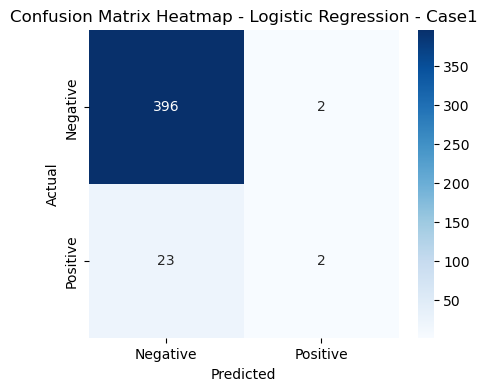

In [179]:
# 1. Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg, average="binary")
recall = recall_score(y_test, y_pred_logreg, average="binary")
f1 = f1_score(y_test, y_pred_logreg, average="binary")

print("Logistic Regression Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Logistic Regression - Case1")
plt.show()


Random Forest Classifier Performance:
Accuracy:  0.9551
Precision: 0.8000
Recall:    0.3200
F1 Score:  0.4571

Confusion Matrix:
True Negatives (TN): 396
False Positives (FP): 2
False Negatives (FN): 17
True Positives (TP): 8



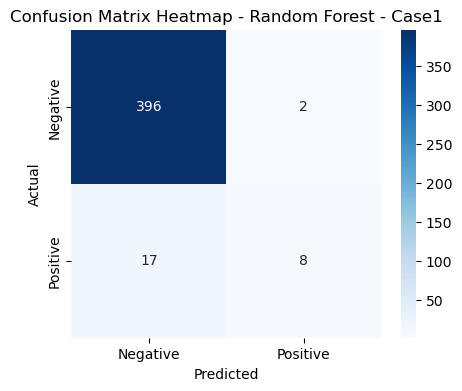

In [180]:
# 2. Random Forest Classifier case 1 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

#Compute metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average="binary")
recall = recall_score(y_test, y_pred_rf, average="binary")
f1 = f1_score(y_test, y_pred_rf, average="binary")

# Print metrics
print("Random Forest Classifier Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Random Forest - Case1")
plt.show()

Gradient Boosting Classifier Performance:
Accuracy:  0.9598
Precision: 0.8333
Recall:    0.4000
F1 Score:  0.5405

Confusion Matrix:
True Negatives (TN): 396
False Positives (FP): 2
False Negatives (FN): 15
True Positives (TP): 10



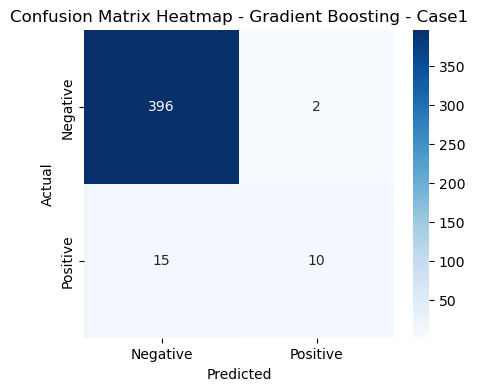

In [181]:
# 3. Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

# Predictions
y_pred_gbm = gbm.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_gbm)
precision = precision_score(y_test, y_pred_gbm, average="binary") 
recall = recall_score(y_test, y_pred_gbm, average="binary")
f1 = f1_score(y_test, y_pred_gbm, average="binary")

# Print metrics
print("Gradient Boosting Classifier Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gbm)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Gradient Boosting - Case1")
plt.show()


•	Very high accuracy (94-96%) missleading 

•	Low recall values (8-40%), meaning most good wines were missed

•	The confusion matrices show very few True Positives (TP)


In [182]:
#BorderlineSMOTE - an improved oversampling algorithm based on SMOTE. 
#Focuses on generating synthetic samples near the decision boundary

# BordelineSMOTE

In [183]:
from imblearn.over_sampling import BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_bal, y_train_bal = borderline_smote.fit_resample(X_train, y_train)

print("Balanced class distribution:", Counter(y_train_bal))

Balanced class distribution: Counter({0: 1590, 1: 1590})


Balanced class distribution: Counter({0: 1590, 1: 1590})


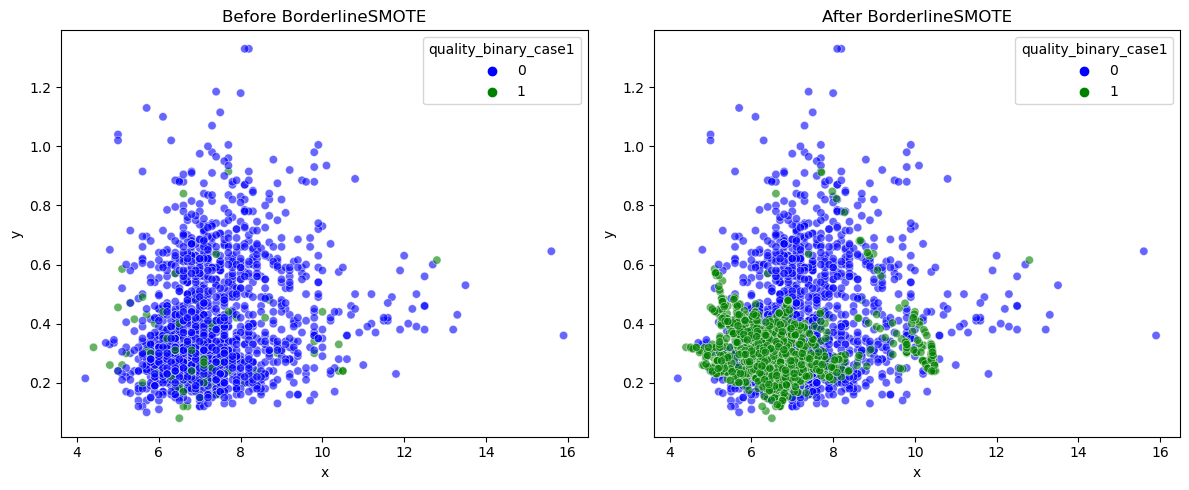

In [184]:
# Apply BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_bal, y_train_bal = borderline_smote.fit_resample(X_train, y_train)
print("Balanced class distribution:", Counter(y_train_bal))

X_train_np = np.array(X_train)  
X_train_bal_np = np.array(X_train_bal)

feat_x, feat_y = 0, 1 

# Plot before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original dataset scatterplot
sns.scatterplot(x=X_train_np[:, feat_x], y=X_train_np[:, feat_y], 
                hue=y_train, palette={0: "blue", 1: "green"}, 
                alpha=0.6, ax=axes[0])
axes[0].set_title("Before BorderlineSMOTE")
axes[0].set_xlabel(f"x")
axes[0].set_ylabel(f"y")

# Balanced dataset scatterplot
sns.scatterplot(x=X_train_bal_np[:, feat_x], y=X_train_bal_np[:, feat_y], 
                hue=y_train_bal, palette={0: "blue", 1: "green"}, 
                alpha=0.6, ax=axes[1])
axes[1].set_title("After BorderlineSMOTE")
axes[1].set_xlabel(f"x")
axes[1].set_ylabel(f"y")

plt.tight_layout()
plt.show()

Logistic Regression Performance:
Accuracy:  0.8605
Precision: 0.2821
Recall:    0.8800
F1 Score:  0.4272

Confusion Matrix:
True Negatives (TN): 342
False Positives (FP): 56
False Negatives (FN): 3
True Positives (TP): 22


/Users/dobrosiasupernak/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


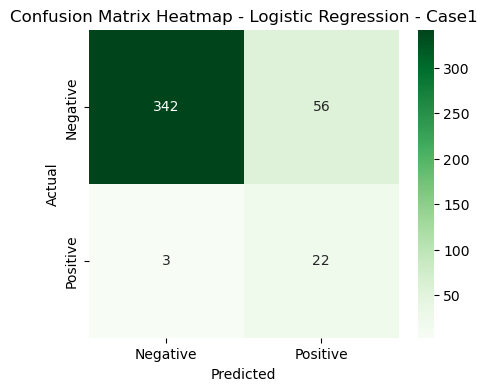

In [185]:
# 1. Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_logreg = logreg.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg, average="binary")
recall = recall_score(y_test, y_pred_logreg, average="binary")
f1 = f1_score(y_test, y_pred_logreg, average="binary")

# Print metrics
print("Logistic Regression Performance2:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Logistic Regression - Case1")
plt.show()


Random Forest Classifier Performance:
Accuracy:  0.9527
Precision: 0.6190
Recall:    0.5200
F1 Score:  0.5652

Confusion Matrix:
True Negatives (TN): 390
False Positives (FP): 8
False Negatives (FN): 12
True Positives (TP): 13



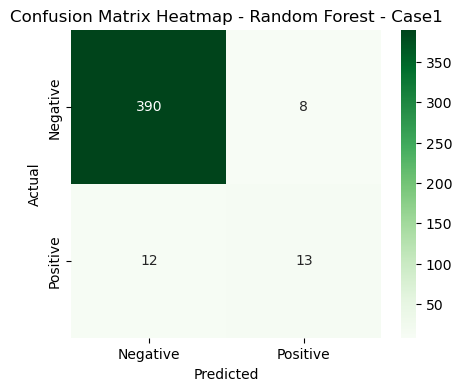

In [186]:
# 2. Random Forest Classifier case 1 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

#Compute metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average="binary")
recall = recall_score(y_test, y_pred_rf, average="binary")
f1 = f1_score(y_test, y_pred_rf, average="binary")

# Print metrics
print("Random Forest Classifier Performance2:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Random Forest - Case1")
plt.show()

Gradient Boosting Classifier Performance:
Accuracy:  0.9291
Precision: 0.4390
Recall:    0.7200
F1 Score:  0.5455

Confusion Matrix:
True Negatives (TN): 375
False Positives (FP): 23
False Negatives (FN): 7
True Positives (TP): 18



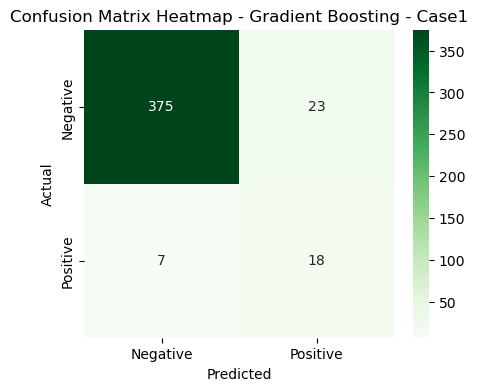

In [187]:
# 3. Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_gbm = gbm.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_gbm)
precision = precision_score(y_test, y_pred_gbm, average="binary") 
recall = recall_score(y_test, y_pred_gbm, average="binary")
f1 = f1_score(y_test, y_pred_gbm, average="binary")

# Print metrics
print("Gradient Boosting Classifier Performance2:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gbm)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Gradient Boosting - Case1")
plt.show()


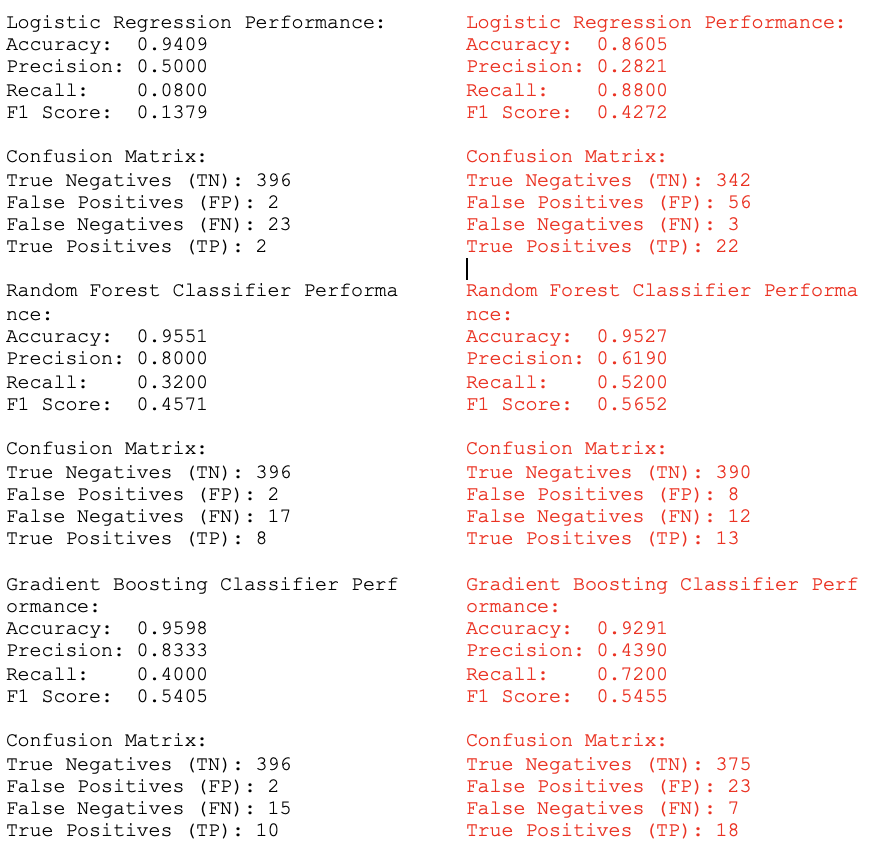

# 2nd scenario

In [188]:
X = wine_imbalanced_2[features]
y_case2 = wine_imbalanced_2['quality_binary_case2']

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y_case2, test_size=0.2, random_state=42)

Logistic Regression Performance after:
Accuracy:  0.9423
Precision: 0.6667
Recall:    0.5000
F1 Score:  0.5714

Confusion Matrix:
True Negatives (TN): 47
False Positives (FP): 1
False Negatives (FN): 2
True Positives (TP): 2


/Users/dobrosiasupernak/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


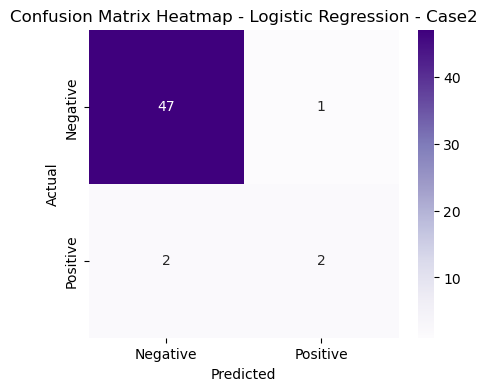

In [190]:
# 1. Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg, average="binary")
recall = recall_score(y_test, y_pred_logreg, average="binary")
f1 = f1_score(y_test, y_pred_logreg, average="binary")

# Print metrics
print("Logistic Regression Performance after:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix in a readable format
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Logistic Regression - Case2")
plt.show()


Random Forest Classifier Performance after:
Accuracy:  0.9231
Precision: 0.5000
Recall:    0.2500
F1 Score:  0.3333

Confusion Matrix:
True Negatives (TN): 47
False Positives (FP): 1
False Negatives (FN): 3
True Positives (TP): 1



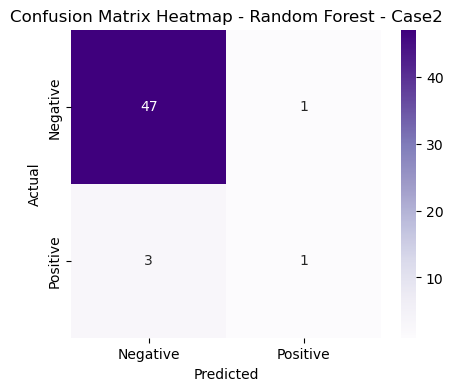

In [191]:
# 2. Random Forest Classifier case 1 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

#Compute metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average="binary")
recall = recall_score(y_test, y_pred_rf, average="binary")
f1 = f1_score(y_test, y_pred_rf, average="binary")

# Print metrics
print("Random Forest Classifier Performance after:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Random Forest - Case2")
plt.show()

Gradient Boosting Classifier Performance after:
Accuracy:  0.9615
Precision: 1.0000
Recall:    0.5000
F1 Score:  0.6667

Confusion Matrix:
True Negatives (TN): 48
False Positives (FP): 0
False Negatives (FN): 2
True Positives (TP): 2



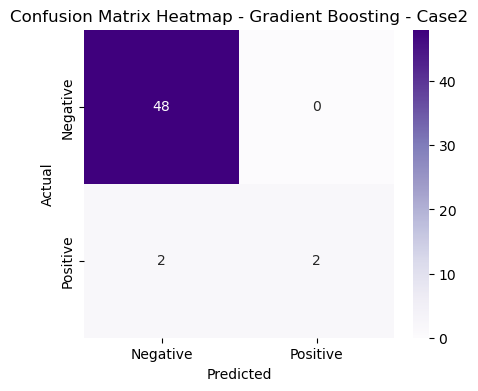

In [192]:
# 3. Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train, y_train)

# Predictions
y_pred_gbm = gbm.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_gbm)
precision = precision_score(y_test, y_pred_gbm, average="binary") 
recall = recall_score(y_test, y_pred_gbm, average="binary")
f1 = f1_score(y_test, y_pred_gbm, average="binary")

# Print metrics
print("Gradient Boosting Classifier Performance after:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gbm)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Gradient Boosting - Case2")
plt.show()


# BorderlineSMOTE case 2

In [193]:
# BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE
borderline_smote = BorderlineSMOTE(random_state=42)
X_train_bal, y_train_bal = borderline_smote.fit_resample(X_train, y_train)

print("Balanced class distribution:", Counter(y_train_bal))

Balanced class distribution: Counter({0: 188, 1: 188})


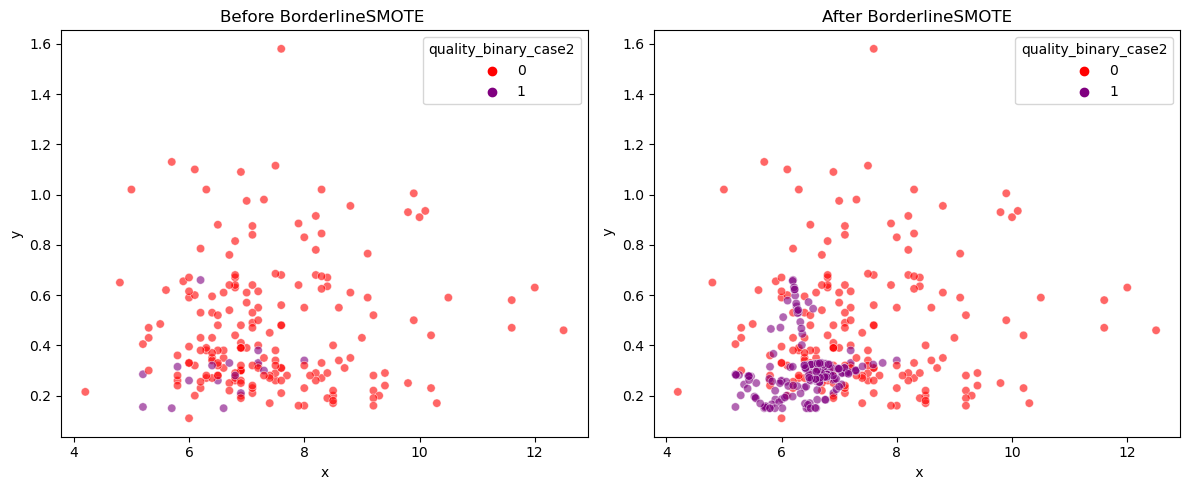

In [194]:
# Convert to numpy arrays for easy plotting
X_train_np = np.array(X_train)  
X_train_bal_np = np.array(X_train_bal)

# Select two features for visualization (first two columns)
feat_x, feat_y = 0, 1  # Change these indices if needed

# Plot before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original dataset scatterplot
sns.scatterplot(x=X_train_np[:, feat_x], y=X_train_np[:, feat_y], hue=y_train, palette={0: "red", 1: "purple"}, alpha=0.6, ax=axes[0])
axes[0].set_title("Before BorderlineSMOTE ")
axes[0].set_xlabel(f"x")
axes[0].set_ylabel(f"y")

# Balanced dataset scatterplot
sns.scatterplot(x=X_train_bal_np[:, feat_x], y=X_train_bal_np[:, feat_y], hue=y_train_bal, palette={0: "red", 1: "purple"}, alpha=0.6, ax=axes[1])
axes[1].set_title("After BorderlineSMOTE")
axes[1].set_xlabel(f" x")
axes[1].set_ylabel(f" y")

plt.tight_layout()
plt.show()

Logistic Regression Performance2:
Accuracy:  0.8846
Precision: 0.3750
Recall:    0.7500
F1 Score:  0.5000

Confusion Matrix:
True Negatives (TN): 43
False Positives (FP): 5
False Negatives (FN): 1
True Positives (TP): 3


/Users/dobrosiasupernak/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


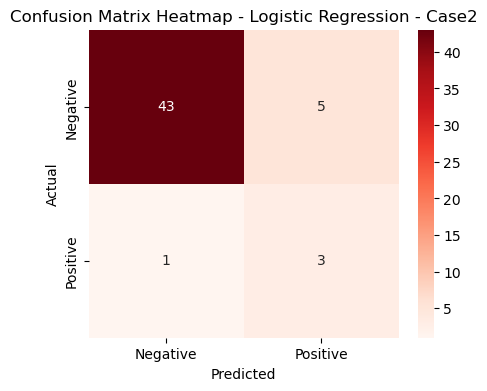

In [198]:
# 1. Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_logreg = logreg.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg, average="binary")
recall = recall_score(y_test, y_pred_logreg, average="binary")
f1 = f1_score(y_test, y_pred_logreg, average="binary")

# Print metrics
print("Logistic Regression Performance2:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix in a readable format
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Logistic Regression - Case2")
plt.show()


Random Forest Classifier Performance2:
Accuracy:  0.9808
Precision: 1.0000
Recall:    0.7500
F1 Score:  0.8571

Confusion Matrix:
True Negatives (TN): 48
False Positives (FP): 0
False Negatives (FN): 1
True Positives (TP): 3



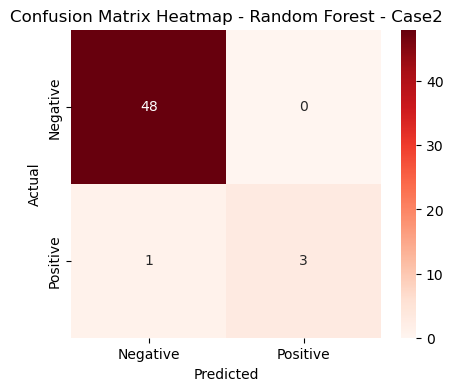

In [199]:
# 2. Random Forest Classifier case 1 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

#Compute metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average="binary")
recall = recall_score(y_test, y_pred_rf, average="binary")
f1 = f1_score(y_test, y_pred_rf, average="binary")

# Print metrics
print("Random Forest Classifier Performance2:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Random Forest - Case2")
plt.show()

Gradient Boosting Classifier Performance2:
Accuracy:  0.9808
Precision: 1.0000
Recall:    0.7500
F1 Score:  0.8571

Confusion Matrix:
True Negatives (TN): 48
False Positives (FP): 0
False Negatives (FN): 1
True Positives (TP): 3



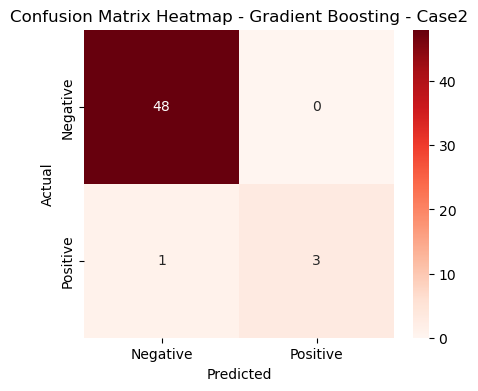

In [200]:
# 3. Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train_bal, y_train_bal)

# Predictions
y_pred_gbm = gbm.predict(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_gbm)
precision = precision_score(y_test, y_pred_gbm, average="binary") 
recall = recall_score(y_test, y_pred_gbm, average="binary")
f1 = f1_score(y_test, y_pred_gbm, average="binary")

# Print metrics
print("Gradient Boosting Classifier Performance2:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gbm)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap - Gradient Boosting - Case2")
plt.show()


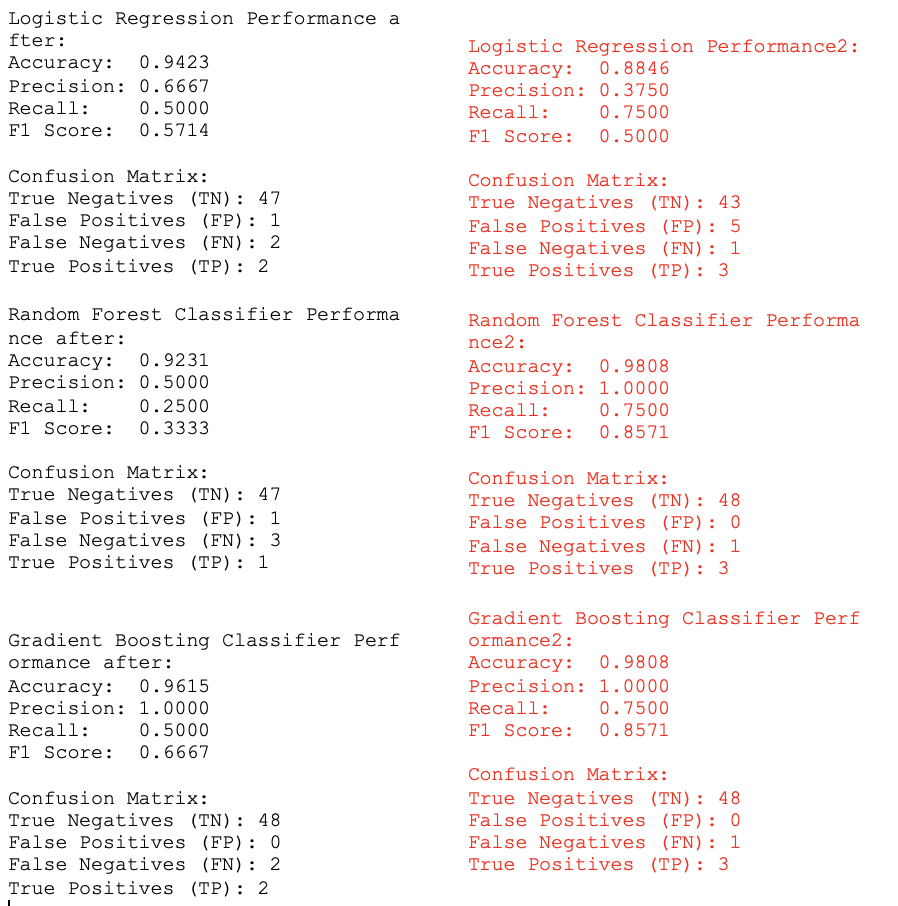